# Data description & Problem statement: 
The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes. Please check the description at: https://archive.ics.uci.edu/ml/datasets/auto+mpg

* The data has 398 rows and 9 variables.
* This is a Regression problem. We predict the Auto MPG.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Cross-validation of Linear Regression model with L1 regularization
- Cross-validation of Linear Regression model with L2 regularization
- Use grid-search along with C-V approach to find the best hyperparameters of Linear Regression model with both L1 & L2 regularizations: Find the best Linear model
   # Model Evaluation: 
- Evaluate the best Linear model with optimized hyperparameters on Test Dataset, by calculating:
     - r2 (determination factor)
     - Lift chart
     - RMSE 
     - Box-plot for prediction Vs. actual values 
     - Distribution plot of error/residuals

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/mpg/mpg.csv')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null int64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null int64
name            398 non-null object
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [3]:
df['horsepower'] = df['horsepower'].apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)
df.drop(['name' ], axis=1, inplace=True)

In [4]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
for name in ['origin']:
    encode_text_dummy(df, name)
    
df.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin-1,origin-2,origin-3
0,18.0,8,307.0,130.0,3504,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 10 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
model_year      392 non-null int64
origin-1        392 non-null uint8
origin-2        392 non-null uint8
origin-3        392 non-null uint8
dtypes: float64(4), int64(3), uint8(3)
memory usage: 25.6 KB


In [6]:
X=df.drop(['mpg'], axis=1)
y=np.log(df['mpg'])

# Re-scaling & Polynomial Interactions:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# Try following feature transformations:
#X['horsepower']=np.log(df['horsepower'])
#X['displacement']=np.log(df['displacement'])

X['horsepower']=100/df['horsepower']
X['displacement']=100/df['displacement']
X['weight']=1000/df['weight']

In [7]:
# Feature selection:
# Univariate Statistics:
#from sklearn.feature_selection import SelectPercentile

#select=SelectPercentile(percentile=70)
#select.fit(X,y)
#X=select.transform(X)

# Model_based selection: RF
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.linear_model import Lasso, Ridge

#from sklearn.feature_selection import SelectFromModel

#select=SelectFromModel(Lasso(alpha=0.01), threshold="0.2*median")

# X=select.fit(X,y).transform(X)


In [8]:
# Re-scaling & Polynomial Interactions:
#from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

poly=PolynomialFeatures(degree=2, include_bias=False)
X=poly.fit(X).transform(X)

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scalor_X=MinMaxScaler().fit(pd.DataFrame(X_train))
X_train=scalor_X.transform(pd.DataFrame(X_train))
X_test=scalor_X.transform(pd.DataFrame(X_test))

scaler_y=MinMaxScaler().fit(pd.DataFrame(y_train))
y_train=scaler_y.transform(pd.DataFrame(y_train))
y_test=scaler_y.transform(pd.DataFrame(y_test))

Max. Lasso score =  0.88


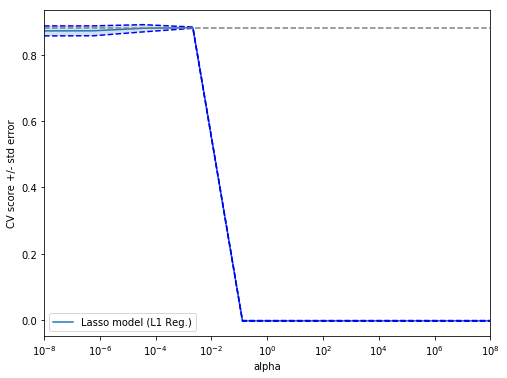

In [9]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

# Cross-Validation for Lasso algorithm: L1 Regularization
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = Lasso(random_state=42)
alphas = np.logspace(-8, 8, 10)

scores = list()
scores_std = list()

n_folds=3
kfold= KFold(n_splits=n_folds, shuffle=True, random_state=42)

for alpha in alphas:
    model.alpha = alpha
    this_scores = cross_val_score(model, X_train, y_train, cv=kfold)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

print("Max. Lasso score = ", round(np.max(scores), 2))

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.legend(['Lasso model (L1 Reg.)'])

Max. Ridge score =  0.89


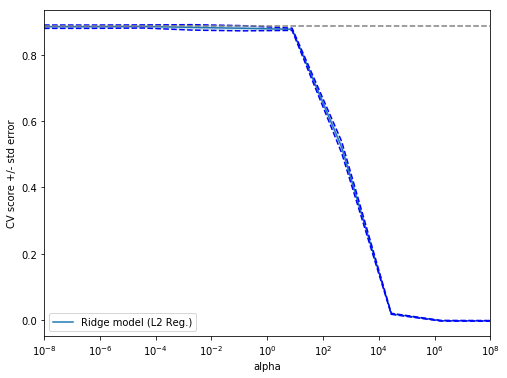

In [10]:
# Cross-Validation for Ridge algorithm: L2 Regularization
model = Ridge(random_state=42)

scores = list()
scores_std = list()

n_folds=3
kfold= KFold(n_splits=n_folds, shuffle=True, random_state=42)

for alpha in alphas:
    model.alpha = alpha
    this_scores = cross_val_score(model, X_train, y_train, cv=kfold)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))
    
scores, scores_std = np.array(scores), np.array(scores_std)

print("Max. Ridge score = ", round(np.max(scores),2))

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.legend(['Ridge model (L2 Reg.)'])

In [11]:
# Grid-Serach for the best ElasticNet parameters: 
from sklearn.model_selection import GridSearchCV

param={'l1_ratio':[0, 0.1, 0.2, 0.3, 0.5, 0.8, 1], 'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.005, 0.01, 0.1, 1]}

kfold=KFold(n_splits=4, shuffle=True, random_state=42)

grid_search=GridSearchCV(ElasticNet(), param, cv=kfold, n_jobs=-1)
grid_search.fit(X_train, y_train)

G=pd.DataFrame(grid_search.cv_results_)
G.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
24,0.037899,0.001411,0.000499,0.000499,0.0001,0.3,"{'alpha': 0.0001, 'l1_ratio': 0.3}",0.876635,0.903150,0.895313,0.882734,0.889417,0.010394,1,0.915760,0.910261,0.912725,0.913329,0.913019,0.001956
23,0.041388,0.002285,0.000749,0.000432,0.0001,0.2,"{'alpha': 0.0001, 'l1_ratio': 0.2}",0.877602,0.902104,0.895683,0.882426,0.889416,0.009864,2,0.917521,0.911697,0.913812,0.914565,0.914399,0.002087
22,0.045129,0.002159,0.000250,0.000432,0.0001,0.1,"{'alpha': 0.0001, 'l1_ratio': 0.1}",0.877567,0.901057,0.896278,0.881646,0.889100,0.009792,3,0.918794,0.912970,0.914938,0.915927,0.915657,0.002101


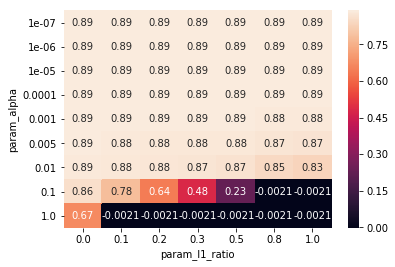

In [12]:
h=G[["param_alpha", "param_l1_ratio", "mean_test_score"]].pivot_table(index="param_alpha", columns="param_l1_ratio", values="mean_test_score")
sns.heatmap(h, annot=True)

In [13]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation score:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[0,"std_test_score"], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'alpha': 0.0001, 'l1_ratio': 0.3}
Best validation score:  0.89 (+/- 0.01)
Test score:  0.88


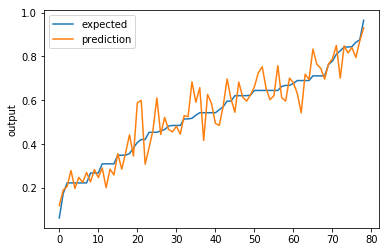

In [14]:
# Plot the Lift Chart:

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

pred=grid_search.predict(X_test)
chart_regression(pred.flatten(), y_test, sort=True)

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_inv=scaler_y.inverse_transform(pd.DataFrame(pred))
y_test_inv=scaler_y.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(np.e**y_test_inv, np.e**pred_inv))
print('Test rmse: ', rmse)

Test rmse:  2.6423365567320123


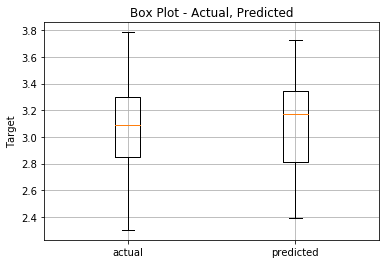

In [16]:
plt.boxplot([y_test_inv.ravel(), pred_inv.ravel()], labels=['actual','predicted'])
plt.title('Box Plot - Actual, Predicted')
plt.ylabel('Target')
plt.grid(True)

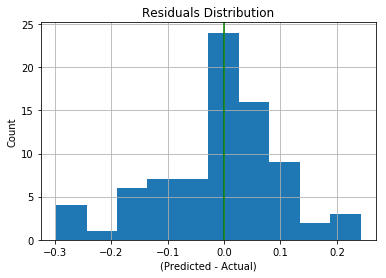

In [17]:
# Over prediction and Under Prediction needs to be balanced:
# Training Data Residuals
residuals = y_test_inv.ravel()-pred_inv.ravel()

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')
plt.show()